In [1316]:
!pip install prophet

In [1317]:
#import dependencies
import pandas as pd
import datetime as dt
from prophet import Prophet
import matplotlib.pyplot as plt

In [1318]:
# # upload US-Monthly-GDP-History-Data.csv
# from google.colab import files
# uploaded = files.upload()

In [1319]:
# for reading in the US-Monthly-GDP-History-Data.csv in jupyter notebook 
# comment out when not in use
df= pd.read_csv('resources/GDPC1.csv', parse_dates= True)
display(df.head(15))
display(df.tail(20))

,DATE,GDPC1
0,1947-01-01,2182.681
1,1947-04-01,2176.892
2,1947-07-01,2172.432
3,1947-10-01,2206.452
4,1948-01-01,2239.682
5,1948-04-01,2276.690
6,1948-07-01,2289.770
7,1948-10-01,2292.364
8,1949-01-01,2260.807
9,1949-04-01,2253.128


,DATE,GDPC1
290,2019-07-01,20843.322
291,2019-10-01,20985.448
292,2020-01-01,20693.238
293,2020-04-01,19056.617
294,2020-07-01,20548.793
295,2020-10-01,20771.691
296,2021-01-01,21058.379
297,2021-04-01,21389.005
298,2021-07-01,21571.421
299,2021-10-01,21960.388


In [1320]:
# drop empty columns and rows
# use .info() to learn more about the dataframe
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    310 non-null    object 
 1   GDPC1   310 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [1321]:
# convert to date to datetime
# set index to 'Date'
# take years only up until 2015

try:
    df['DATE'] = pd.to_datetime(df['DATE'], errors = 'coerce')
except Exception as e:
    print(e)

df = df.dropna(subset=['DATE'])
gdp_df= df.set_index('DATE')

gdp_df = gdp_df.loc['1983':'2015']
gdp_df

,GDPC1
DATE,
1983-01-01,7400.066
1983-04-01,7568.456
1983-07-01,7719.746
1983-10-01,7880.794
1984-01-01,8034.847
...,...
2014-10-01,18500.031
2015-01-01,18666.621
2015-04-01,18782.243


<Axes: xlabel='DATE'>

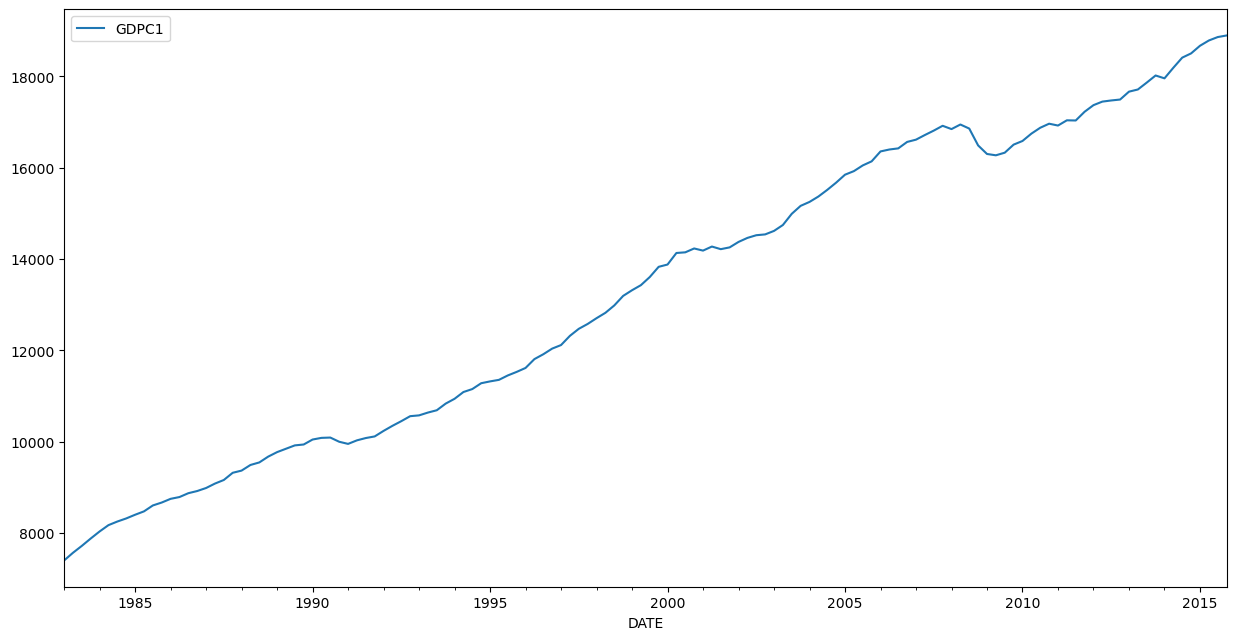

In [1322]:
# visualize the dataframe
gdp_df.plot(figsize=(15, 7.5))

<Axes: xlabel='DATE'>

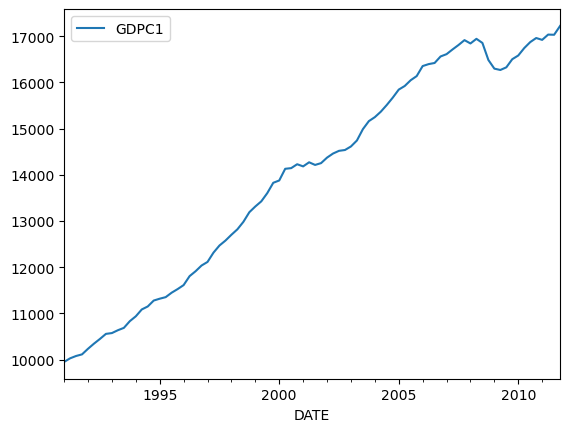

In [1323]:
# visualize GDP from 1991 to 10 years after 9/11
gdp_df.loc['1991':'2011'].plot()


In [1324]:
# reset index for gdp_df to prepare for prophet
gdp_rs_index_df = gdp_df.reset_index()
gdp_rs_index_df

,DATE,GDPC1
0,1983-01-01,7400.066
1,1983-04-01,7568.456
2,1983-07-01,7719.746
3,1983-10-01,7880.794
4,1984-01-01,8034.847
...,...,...
127,2014-10-01,18500.031
128,2015-01-01,18666.621
129,2015-04-01,18782.243
130,2015-07-01,18857.418


In [1325]:
# slice gdp_rs_index_df up until 2001-09
# rename columns to 'ds', 'y'
nine_eleven_gdp_df = gdp_rs_index_df.loc[gdp_rs_index_df['DATE'] < '2001-09']
nine_eleven_gdp_df.columns = ['ds', 'y']
nine_eleven_gdp_df.head()

,ds,y
0,1983-01-01,7400.066
1,1983-04-01,7568.456
2,1983-07-01,7719.746
3,1983-10-01,7880.794
4,1984-01-01,8034.847


In [1326]:
# # Call the Prophet function, store as an object
model_9_11 = Prophet()
model_9_11

In [1327]:
# fit the Prophet model
model_9_11.fit(nine_eleven_gdp_df)

12:59:35 - cmdstanpy - INFO - Chain [1] start processing
12:59:37 - cmdstanpy - INFO - Chain [1] done processing


In [1328]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 3 years
future_9_11 = model_9_11.make_future_dataframe(periods=3, freq= 'Y')

# View the last five rows of the predictions
future_9_11.tail()



c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


,ds
73,2001-04-01
74,2001-07-01
75,2001-12-31
76,2002-12-31
77,2003-12-31


In [1329]:

# Make the predictions for the trend data using the future_trends DataFrame
forecast_9_11 = model_9_11.predict(future_9_11)

# Display the first five rows of the forecast DataFrame
forecast_9_11.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1983-01-01,13557.838138,7392.985847,7570.726284,13557.838138,13557.838138,-6077.770440,-6077.770440,-6077.770440,-6077.770440,-6077.770440,-6077.770440,0.0,0.0,0.0,7480.067697
1,1983-04-01,13672.482744,7502.792608,7671.035706,13672.482744,13672.482744,-6083.131993,-6083.131993,-6083.131993,-6083.131993,-6083.131993,-6083.131993,0.0,0.0,0.0,7589.350752
2,1983-07-01,13788.401180,7646.111223,7814.732545,13788.401180,13788.401180,-6057.295809,-6057.295809,-6057.295809,-6057.295809,-6057.295809,-6057.295809,0.0,0.0,0.0,7731.105371
3,1983-10-01,13905.593443,7794.997634,7965.807727,13905.593443,13905.593443,-6025.021370,-6025.021370,-6025.021370,-6025.021370,-6025.021370,-6025.021370,0.0,0.0,0.0,7880.572073
4,1984-01-01,14022.785706,7886.180048,8062.362924,14022.785706,14022.785706,-6045.251613,-6045.251613,-6045.251613,-6045.251613,-6045.251613,-6045.251613,0.0,0.0,0.0,7977.534093


c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


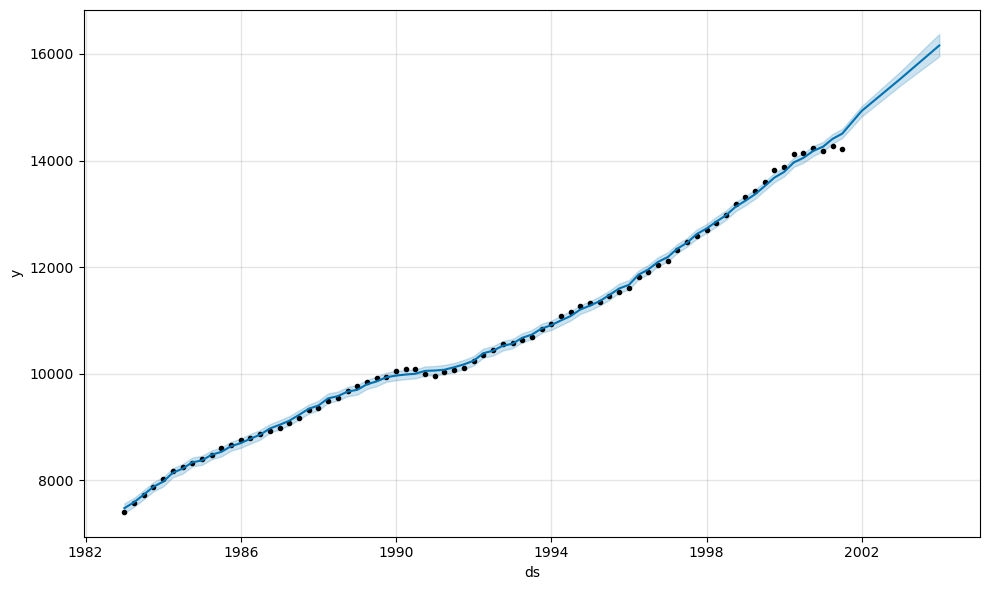

In [1330]:
# Plot the Prophet predictions for the 9/11 trends data
# slice the forecast_9_11 trends to start from 1991 for better presentation
model_9_11.plot(forecast_9_11)
forecast_9_11 = forecast_9_11.loc[forecast_9_11['ds'] >= '1991']

c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain

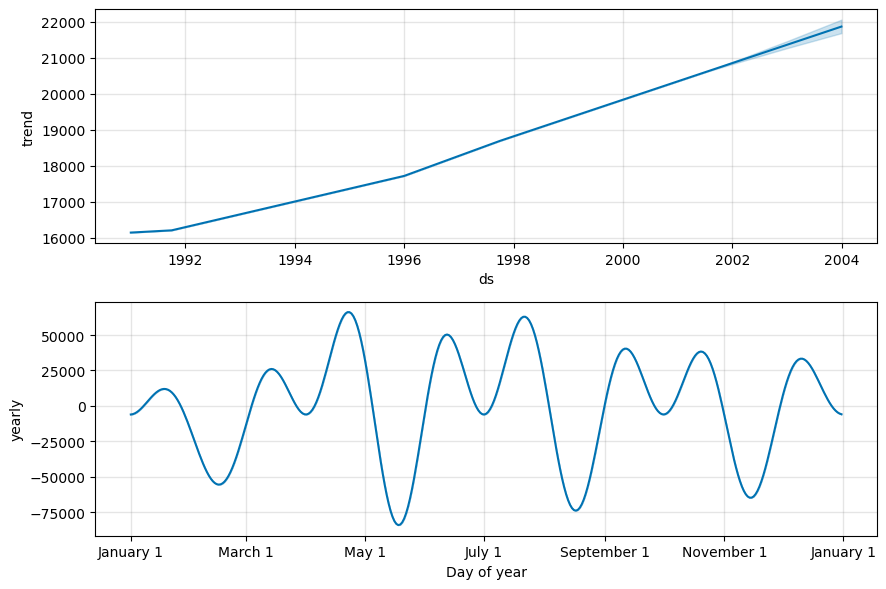

In [1331]:
# Use the plot_components function to visualize the forecast results
figure = model_9_11.plot_components(forecast_9_11)

<Axes: xlabel='ds'>

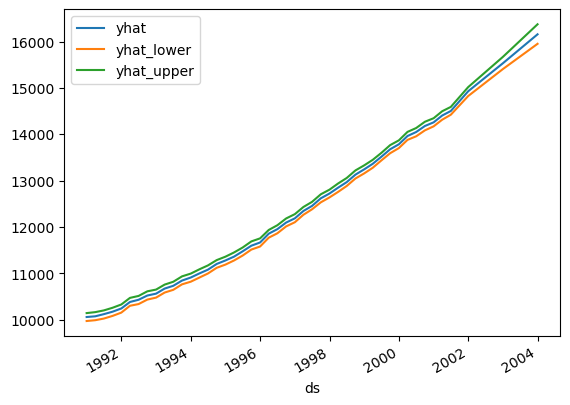

In [1332]:
# set 'ds' as index
# From the `forecast_9_11` DataFrame, plot to visualize
# the yhat, yhat_lower, and yhat_upper columns
forecast_9_11 = forecast_9_11.set_index('ds')
forecast_9_11[['yhat', 'yhat_lower', 'yhat_upper']].plot()

<Axes: xlabel='DATE'>

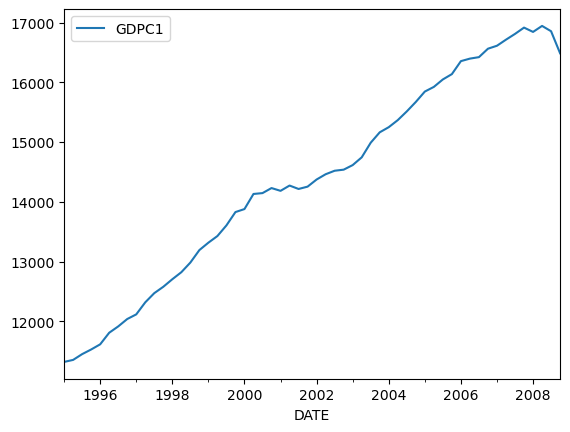

In [1333]:
# create a df for hurricane Katrina
gdp_df.loc['1995':'2008'].plot()


In [1334]:
# slice gdp_rs_index_df from 1992 to 2005-08
# rename columns to 'ds', 'y'
katrina_gdp_df = gdp_rs_index_df.loc[gdp_rs_index_df['DATE'] < '2005-08']
katrina_gdp_df.columns = ['ds', 'y']
katrina_gdp_df.head()

,ds,y
0,1983-01-01,7400.066
1,1983-04-01,7568.456
2,1983-07-01,7719.746
3,1983-10-01,7880.794
4,1984-01-01,8034.847


In [1335]:
# # Call the Prophet function, store as an object
model_katrina = Prophet()
model_katrina

In [1336]:
# # fit the Prophet model
model_katrina.fit(katrina_gdp_df)

12:59:40 - cmdstanpy - INFO - Chain [1] start processing
12:59:41 - cmdstanpy - INFO - Chain [1] done processing


In [1337]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 3 years
future_katrina = model_katrina.make_future_dataframe(periods=3, freq='Y')

# View the last five rows of the predictions
future_katrina.tail()



c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


,ds
89,2005-04-01
90,2005-07-01
91,2005-12-31
92,2006-12-31
93,2007-12-31


In [1338]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_katrina = model_katrina.predict(future_katrina)

# Display the first five rows of the forecast DataFrame
forecast_katrina.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1983-01-01,18528.383474,7392.306919,7584.195134,18528.383474,18528.383474,-11036.903119,-11036.903119,-11036.903119,-11036.903119,-11036.903119,-11036.903119,0.0,0.0,0.0,7491.480356
1,1983-04-01,18625.879157,7461.363712,7660.066339,18625.879157,18625.879157,-11059.572260,-11059.572260,-11059.572260,-11059.572260,-11059.572260,-11059.572260,0.0,0.0,0.0,7566.306897
2,1983-07-01,18724.458124,7615.055928,7812.876731,18724.458124,18724.458124,-11009.096212,-11009.096212,-11009.096212,-11009.096212,-11009.096212,-11009.096212,0.0,0.0,0.0,7715.361912
3,1983-10-01,18824.120377,7773.996714,7969.683710,18824.120377,18824.120377,-10950.584144,-10950.584144,-10950.584144,-10950.584144,-10950.584144,-10950.584144,0.0,0.0,0.0,7873.536233
4,1984-01-01,18923.782630,7871.364145,8069.776299,18923.782630,18923.782630,-10951.880284,-10951.880284,-10951.880284,-10951.880284,-10951.880284,-10951.880284,0.0,0.0,0.0,7971.902347


c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


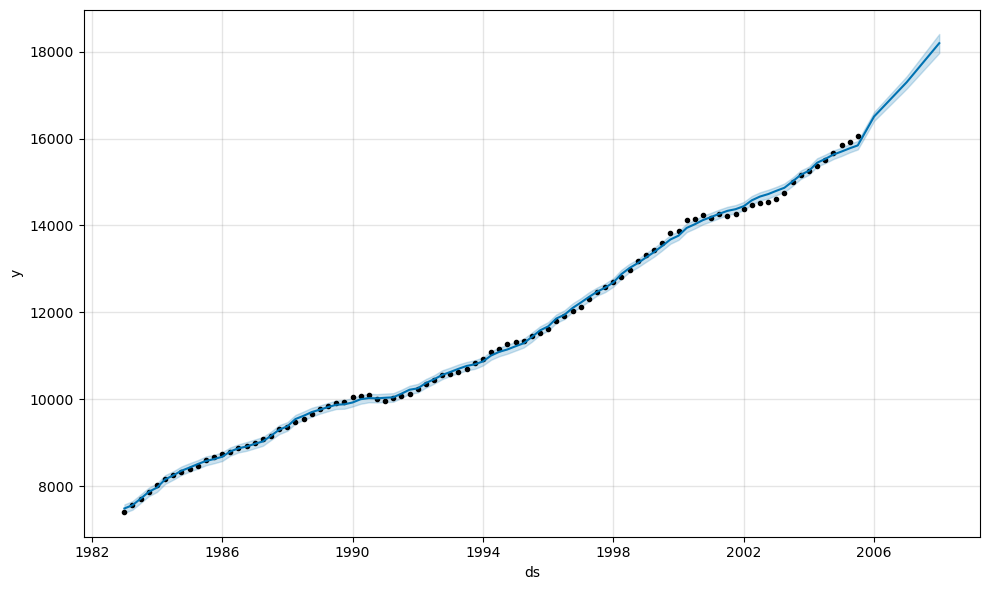

In [1339]:

#  Plot the Prophet predictions for the katrina trends data
#slice the forecast_katrina to dates only after 1995 for better presentation
model_katrina.plot(forecast_katrina)
forecast_katrina = forecast_katrina.loc[forecast_katrina['ds'] >= '1995']

c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\linan\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain

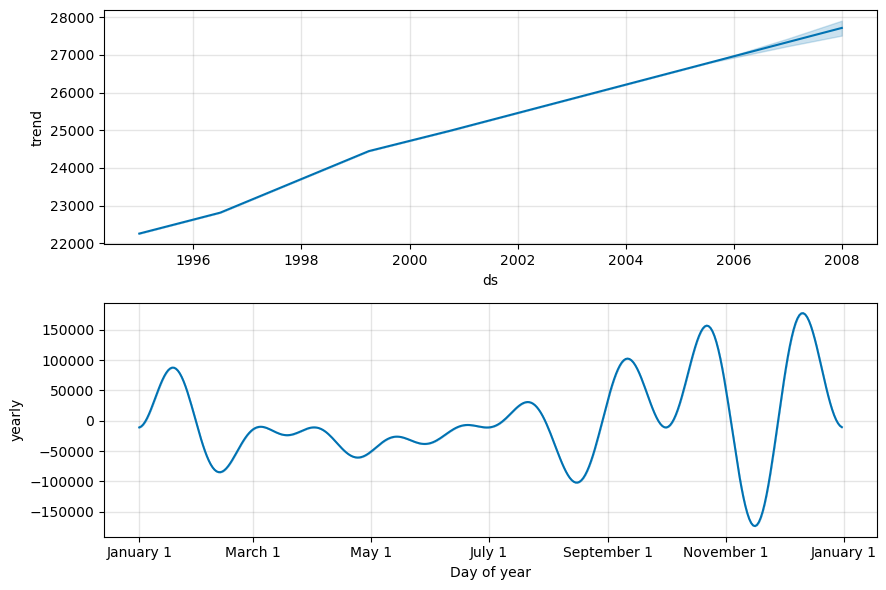

In [1340]:
# Use the plot_components function to visualize the forecast results
figure = model_katrina.plot_components(forecast_katrina)

<Axes: xlabel='ds'>

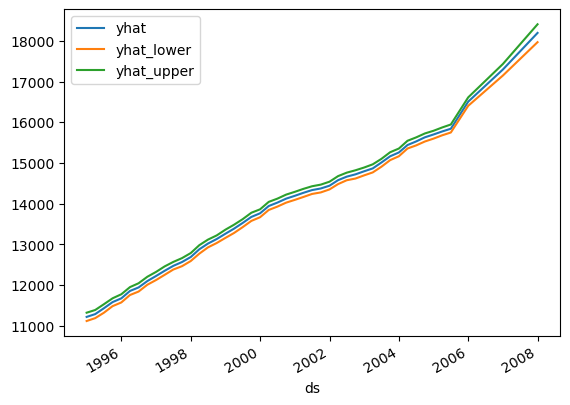

In [1341]:
# set 'ds' as index
# From the `forecast_katrina` DataFrame, plot to visualize
# the yhat, yhat_lower, and yhat_upper columns
forecast_katrina = forecast_katrina.set_index('ds')
forecast_katrina[['yhat', 'yhat_lower', 'yhat_upper']].plot()

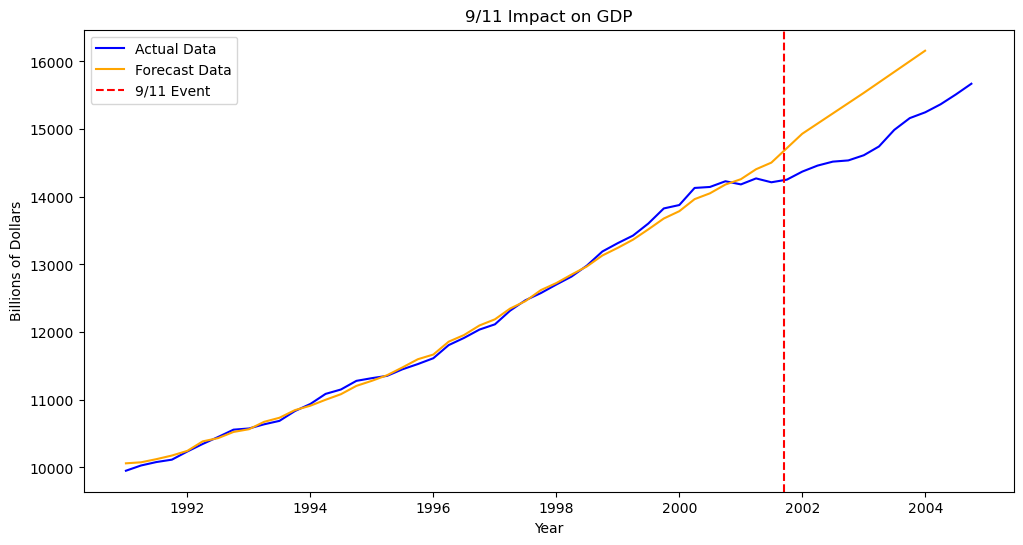

In [1342]:
# Create a figure with a specified size
plt.figure(figsize=(12, 6))


# create nine_eleven_actual_gdp_df which is the gdp_df sliced from 1992 to 2004
# plot nine_eleven_actual_gdp_df and the forecast in the same plot

nine_eleven_actual_gdp_df= gdp_df.loc['1991':'2004']
plt.plot(nine_eleven_actual_gdp_df.index, nine_eleven_actual_gdp_df['GDPC1'], label = 'Actual Data', color= 'blue')
plt.plot(forecast_9_11.index, forecast_9_11['yhat'], label= 'Forecast Data', color = 'orange')
plt.title('9/11 Impact on GDP')
plt.xlabel('Year')
plt.ylabel('Billions of Dollars')
# make the vertical event line for 2001-09-11

event_date = pd.to_datetime('2001-09-11')
plt.axvline(x=event_date, color='red', linestyle='--', label='9/11 Event')
plt.legend()
plt.show()


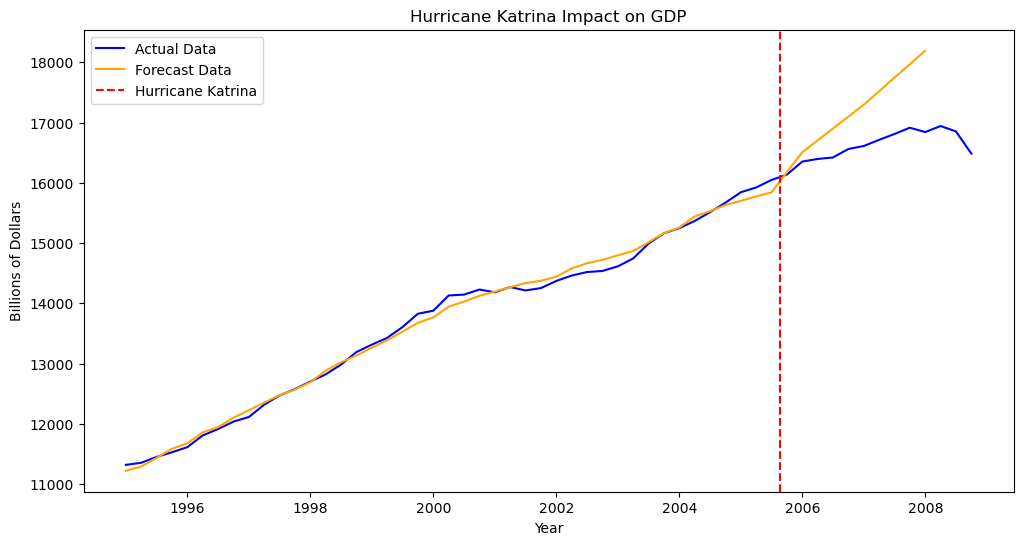

In [1343]:
# Create a figure with a specified size
plt.figure(figsize=(12, 6))

# create katrina_actual_gdp_df which is the gdp_df sliced from 1992 to 2008
# plot katrina_actual_gdp_df and the forecast in the same plot
# create a legend
katrina_actual_gdp_df= gdp_df.loc['1995':'2008']
plt.plot(katrina_actual_gdp_df.index, katrina_actual_gdp_df['GDPC1'], label = 'Actual Data', color= 'blue')
plt.plot(forecast_katrina.index, forecast_katrina['yhat'], label= 'Forecast Data', color= 'orange')
plt.title('Hurricane Katrina Impact on GDP')
plt.xlabel('Year')
plt.ylabel('Billions of Dollars')

# make the vertical event line for 2001-09-11
event_date = pd.to_datetime('2005-08-23')
plt.axvline(x=event_date, color='red', linestyle='--', label='Hurricane Katrina')

plt.legend()
plt.show()

In [1344]:
# export gdp_df as csv
# export forecast_9_11 as csv
# export forecast_katrina as csv
gdp_df.to_csv('resources/gdp_cleaned.csv')
forecast_9_11.to_csv('resources/forecast_9_11_gdp.csv')
forecast_katrina.to_csv('resources/forecast_katrina_gdp.csv')